<a href="https://colab.research.google.com/github/mathfish/LearningTopics/blob/main/Books/PytorchMastery/CustomDataSets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import requests
from pathlib import Path
import pathlib
import zipfile

import os
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
from typing import Tuple, Dict, List
from tqdm.auto import tqdm


# Custom Datasets

* Use your own dataset in PyTorch
* Each PyTorch domain has its own datasets: torchtext.datasets
* Also torchdata has helper functions

Will start with a subset of the Food 101 dataset in torch.vision. It has 3 food classes and only 10% of the images. This is a good practice with starting out with a new model.

# Get Data

In [2]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if not image_path.is_dir():
  print(f"Make diretory at {image_path}")
  image_path.mkdir(parents=True, exist_ok=True)


Make diretory at data/pizza_steak_sushi


In [3]:
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Download data . .. ")
  f.write(request.content)

# unzip data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzip data . . . ")
  zip_ref.extractall(image_path)

Download data . .. 
Unzip data . . . 


# Prepare Data And Explore Data

In [4]:
# Uses standard way to define classes, using directories

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [5]:
# Setup training and test paths

train_dir = image_path / "train"
test_dir = image_path / "test"

Image path is data/pizza_steak_sushi/test/pizza/309892.jpg of type class pizza
Image (h x w x c): 333 x 512 x 3


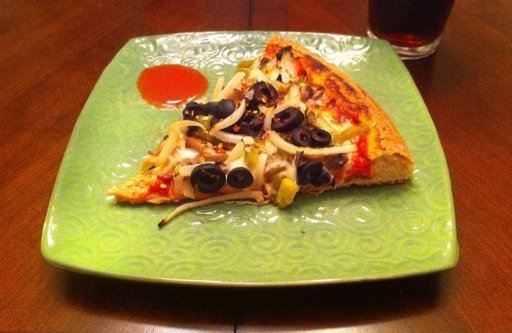

In [6]:
''' visualize the data: get all paths, get random image, get class name based on folder
  , and will use Python image library (PIL) via pillow and print metadata
'''

random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print(f"Image path is {random_image_path} of type class {image_class}")
print(f"Image (h x w x c): {img.height} x {img.width} x {img.layers}")

# could also use plt.imshow
img

In [7]:
# turn img into numpy array
img_as_array = np.asarray(img)

## Turn into Tensors

We need to turn our data $\rightarrow$ tensors $\rightarrow$ `torch.utils.data.Dataset` $\rightarrow$ `torch.utils.data.DataLoader`

There is a `transform` parameter in the `torchvision.dataset.ImageFolder` package (there are equivalent ones in other domains) and transforms the data

In [8]:
# Create a list of transforms

data_transform = transforms.Compose(
    # resize images to 64 x 64
    [transforms.Resize(size=(64, 64)),
    # randomly flip images on horizontal
     transforms.RandomHorizontalFlip(p=0.5),
    # turn image into torch tensor
     transforms.ToTensor()
    ]
)

In [9]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  if seed is not None:
    random.seed(42)

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


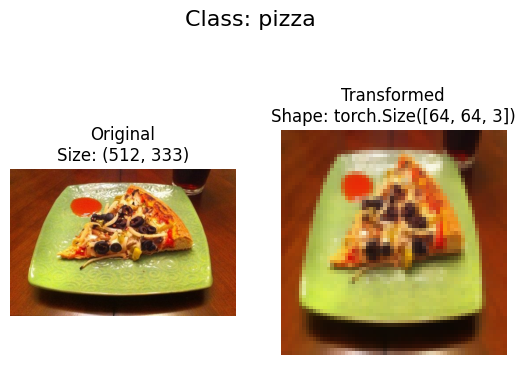

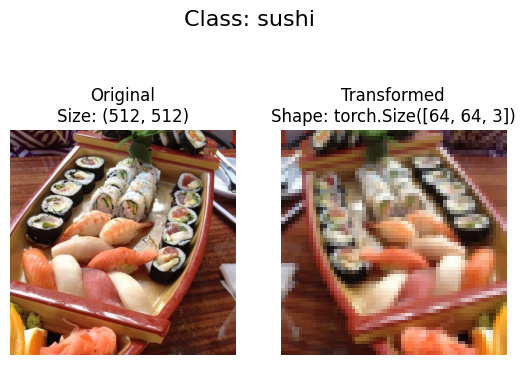

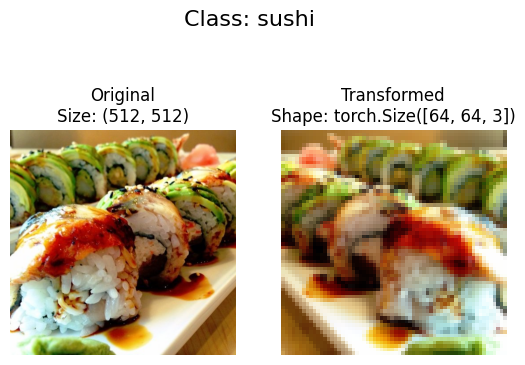

In [11]:
plot_transformed_images(image_path_list, data_transform, seed=42)

In [12]:
# Option 1: Can use ImageFolder -> prebuilt dataset function
## We can use this since our train and test data follows standard image
## classification format, with class as directories

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform for data
                                  target_transform=None)    # transfomr for label

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform,
                                  target_transform=None)

In [13]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
print(f"Image shape: {train_data[0][0].shape}")
print(f"Image type: {type(train_data[0][0])}")
print(f"Dtype: {train_data[0][0].dtype}")

Image shape: torch.Size([3, 64, 64])
Image type: <class 'torch.Tensor'>
Dtype: torch.float32


In [17]:
# Turn into data loader

BATCH_SIZE = 32
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c901b1d48b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c901b1d4520>)

In [18]:
print(f"length of train_dataloader: {len(train_dataloader)} -> 225/32 ")

img, label = next(iter(train_dataloader))

print(f"Shape of img: {img.shape}")

length of train_dataloader: 8 -> 225/32 
Shape of img: torch.Size([32, 3, 64, 64])


## How to Replicate ImageFolder Functionality

* Want to load images from file
* Want to get class names from Dataset
* Want to get classes as dict from Dataset

Will build off of base Dataset in Pytorch

In [19]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}...")

  class_to_idx = {class_name:i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [20]:
class ImageFolderCustom(Dataset):

  def __init__(self, targ_dir: str, transform=None):
    # get all paths within a target directory
    self.paths = list(Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    '''returns total number of samples'''
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    '''required for subclass: returns one sample of data and label'''

    img = self.load_image(index)
    # expects path format: data_folder/class_name/image.jpg
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      img = self.transform(img)

    return img, class_idx

In [21]:
# Create a transform

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])


test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [22]:
# test our our custom dataset

train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=train_transforms)


In [23]:
len(train_data_custom), len(train_data)

(225, 225)

In [24]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [25]:
# Display random images from dataset

# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

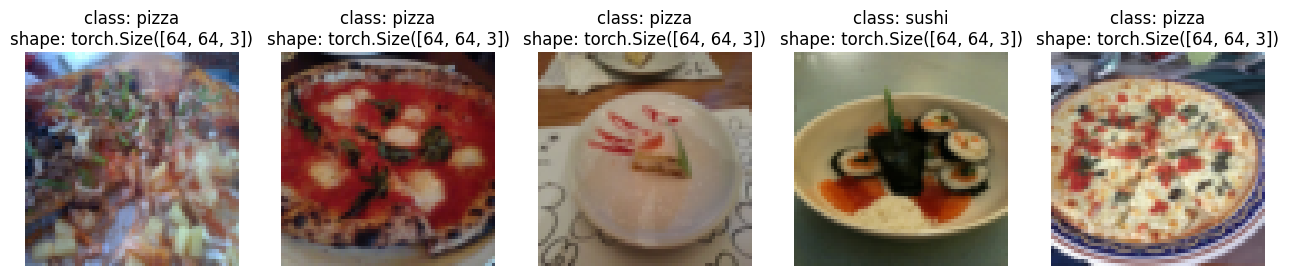

In [26]:
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

In [27]:
# Turn custom datasets into dataloaders

BATCH_SIZE = 32
train_dataloader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True
)

test_dataloader_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=False
)


# Data Augmentation

Focus on one type: Trivial Augmentation, which is used in SOTA models

In [28]:
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

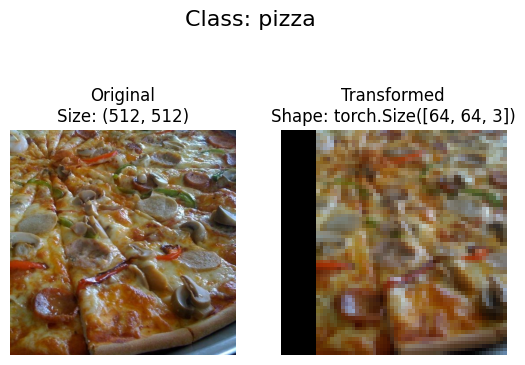

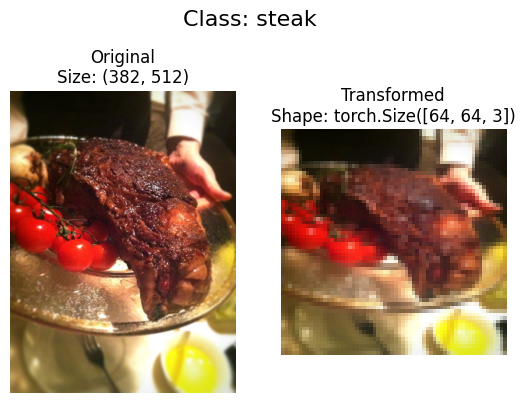

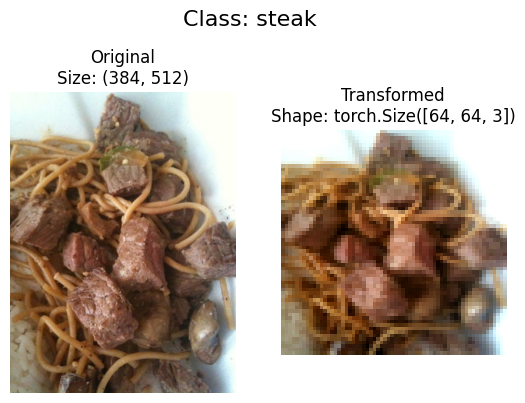

In [29]:
plot_transformed_images(image_path_list, train_transform)

# Train Base Model

Using again TinyVGG. Will first train without data augmentation and then with data augmentation

In [30]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_data_simple = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transform
)

test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transform
)


train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=32,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=32,
                                     num_workers=0,
                                     shuffle=False)


In [57]:
class TinyVGG(nn.Module):

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
        )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
        )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )

  def forward(self, x):
    '''
    Rather than doing this approach, can nest the classes
    self.classifier(self.conv_block_2(self.conv_block_1(x)))

    This alows for operator fusion and is faster for work on the GPU
    '''
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    return self.classifier(x)


In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [59]:
torch.manual_seed(42)


model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

In [60]:
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [61]:
## Try forward pass on single image batch for testing dimensionality and other

image_batch, label_batch = next(iter(train_dataloader_simple))

image_batch.shape

torch.Size([32, 3, 64, 64])

In [62]:
'''
First time failed since we only used hidden_units as the input features
size for linear layer. Outputting the shape after each step in forward
shows we need to multiply hidden_units * 13 * 13
'''

model_0(image_batch.to(device))

tensor([[0.0578, 0.0634, 0.0351],
        [0.0657, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0376],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0349],
        [0.0620, 0.0599, 0.0371],
        [0.0607, 0.0628, 0.0387],
        [0.0638, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0689, 0.0330],
        [0.0557, 0.0571, 0.0356],
        [0.0632, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0368],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0637, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

## Use torchinfo

Helps understand the shapes going through our model. So we don't need to do shape prints  

In [63]:
try:
  import torchinfo
except ModuleNotFoundError as err:
  !pip install torchinfo
finally:
  from torchinfo import summary

In [64]:
summary(model_0,
        input_size=(1, 3, 64, 64) # size of a single image (batch, channel, height, width)
        )

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## Training Steps

In [65]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

  # set to train
  model.train()

  # init loss and accuracy
  train_loss, train_acc = 0, 0

  # loop through batches
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # forward pass
    y_pred = model(X)

    # calc loss and accumulate
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # zero out grad in optimizer
    optimizer.zero_grad()

    # back prop
    loss.backward()

    # step forward optimizer
    optimizer.step()

    # Calc accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  # Adjust for loss and accuracy avg per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      y_pred_logits = model(X)
      loss = loss_fn(y_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = torch.softmax(y_pred_logits, dim=1).argmax(dim=1)
      test_acc += (test_pred_labels == y).sum().item() / len(y_pred_logits)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module=nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
             }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model,
                                       train_dataloader,
                                       loss_fn,
                                       optimizer,
                                       device)

    test_loss, test_acc = test_step(model,
                                       train_dataloader,
                                       loss_fn,
                                       device)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)

In [66]:
from timeit import default_timer as timer

In [68]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

start_time = timer()

model_0_results = train(model_0,
                        train_dataloader_simple,
                        test_dataloader_simple,
                        optimizer,
                        loss_fn,
                        NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1078, Train acc: 0.2578, Test loss: 1.0951, Test acc: 0.3047
Epoch: 1 | Train loss: 1.1197, Train acc: 0.3164, Test loss: 1.1049, Test acc: 0.2930
Epoch: 2 | Train loss: 1.0950, Train acc: 0.4141, Test loss: 1.0926, Test acc: 0.4141
Epoch: 3 | Train loss: 1.1113, Train acc: 0.2930, Test loss: 1.1093, Test acc: 0.2930
Epoch: 4 | Train loss: 1.0955, Train acc: 0.4141, Test loss: 1.1025, Test acc: 0.2930
Total training time: 14.740 seconds


In [74]:
def plot_loss_curves(results):
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  acc = results["train_acc"]
  test_acc = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train loss")
  plt.plot(epochs, test_loss, label="test loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, label="train acc")
  plt.plot(epochs, test_acc, label="test acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")

  plt.legend()

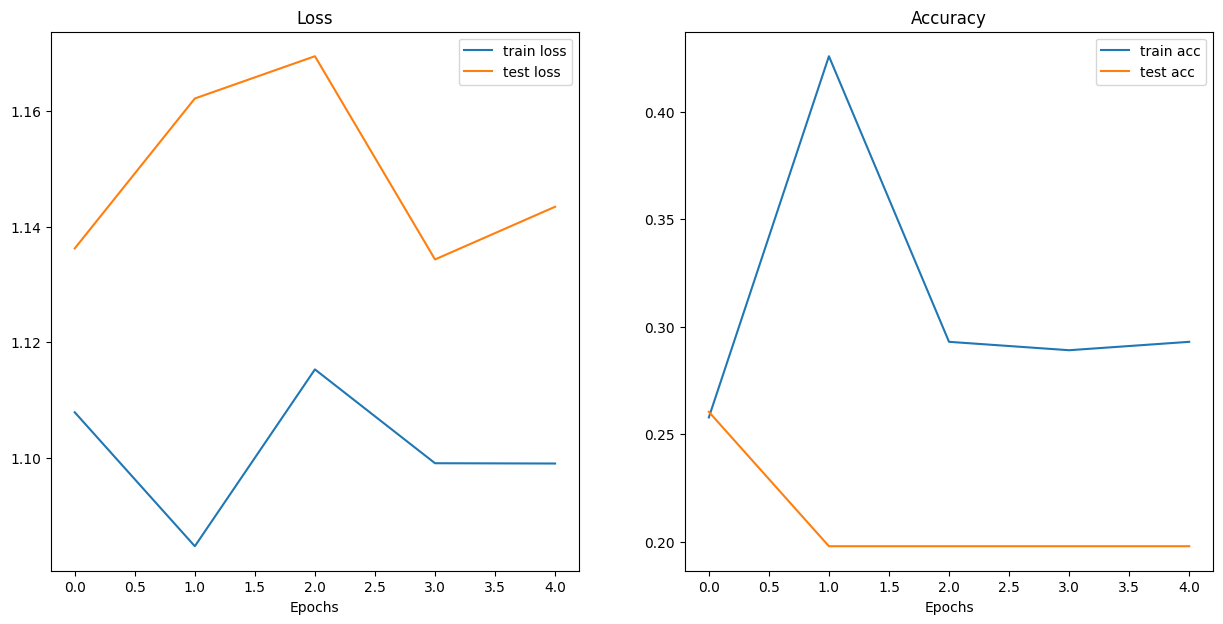

In [75]:
plot_loss_curves(model_0_results)

In [78]:
# with augmentation
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_data_augmented = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform_trivial
)

test_data_augmented = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform_trivial
)

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                     batch_size=32,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_augmented = DataLoader(dataset=test_data_augmented,
                                     batch_size=32,
                                     num_workers=0,
                                     shuffle=False)

In [79]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

start_time = timer()

model_1_results = train(model_1,
                        train_dataloader_augmented,
                        test_dataloader_augmented,
                        optimizer,
                        loss_fn,
                        NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1080 | train_acc: 0.2578 | test_loss: 1.1337 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0869 | train_acc: 0.3984 | test_loss: 1.1446 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.0817 | train_acc: 0.4141 | test_loss: 1.1697 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.1455 | train_acc: 0.2930 | test_loss: 1.1741 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1095 | train_acc: 0.2930 | test_loss: 1.1015 | test_acc: 0.1979
Total training time: 12.054 seconds
